<a href="https://colab.research.google.com/github/jasonbuchanan145/Data-Modeling-Doodles/blob/iris/ML_Fundamentals_Iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Iris Flower Classification

**Group Members**
- Jason Buchanan 	101172155
- Adrian John 		101160410  

Github: https://github.com/jasonbuchanan145/Data-Modeling/blob/main/iris/ML_Fundamentals_Iris.ipynb

**Objective**

This project provides a comparison of Supoort Vector Machine (SVM) parameters that are best suited to predict three species of Iris flowers: Setosa, Versicolor, and Virginica based on their sepal and petal measurements.


**Method**

In this Colab document we demonstrate the following:

Explore the Iris Dataset for different species of flowers, preprocess the data and ensure the data is well suited for this task, check for missing values, create scatter plots and heatmaps as well as other preprocessing analysis

Use of the Scikit-learn library to create an SVM, load our data and experiment with different parameters from the documentation including kernel, gamma and, for the polynomial kernel, the degree

Utilize K-fold cross validation to validate the choices of the SVM parameters

Examine how the accuracy, precision, recall and f1 score change in response to changes to SVM parameters

Provide documentation, graphs and comments to explain our approach as well as our results

Finalize the data in a table and graph our results

**Findings**

We find that overall an SVM utilizing a linear kernel was best suited for this task. For linear the gamma value did not have an impact, whereas it did for other SVM kernels. A full table and chart detailing each kernel, gamma and polynomial value is available at the end of this document.



**Dependencies - Install**

In [31]:
!pip install -q pandas
!pip install -q scikit-learn
!pip install -q matplotlib
!pip install -q seaborn
!pip install -q numpy

print("Requirements Installed")

Requirements Installed


**Dependencies - Import**

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold
import numpy as np
import statistics

**Load the dataset**

In [33]:
iris = load_iris()

feature_names = ["sepal_length", "sepal_width", "petal_length", "petal_width"]

dataset = pd.DataFrame(data=iris.data, columns=feature_names)

dataset['class'] = iris.target
dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


**Analysis - Check Data for Missing Values**

We should check the data for missing values to see if we need to apply transforms to account for the missing data.

As seen below there are no missing values

In [34]:
missing_value_count = dataset.isna().sum().sum()
if missing_value_count>0:
  print("There are {} missing values".format(missing_value_count))
else:
  print("There are no missing values")

There are no missing values


**Analysis - Count Number of Samples for Each Class**

To verify the data is balanced and does not skew towards a particular class we can check the count of each class in the dataset

In [35]:
print(dataset['class'].value_counts())

class
0    50
1    50
2    50
Name: count, dtype: int64


The dataset is balanced with 50 of each class

**Analysis - HeatMaps**

The heatmaps shows the distribution of data among the 4 features with 3 classes.  Based on this distribution, the Support Vector Machine algorithm seems to be the ideal choice to train the model.

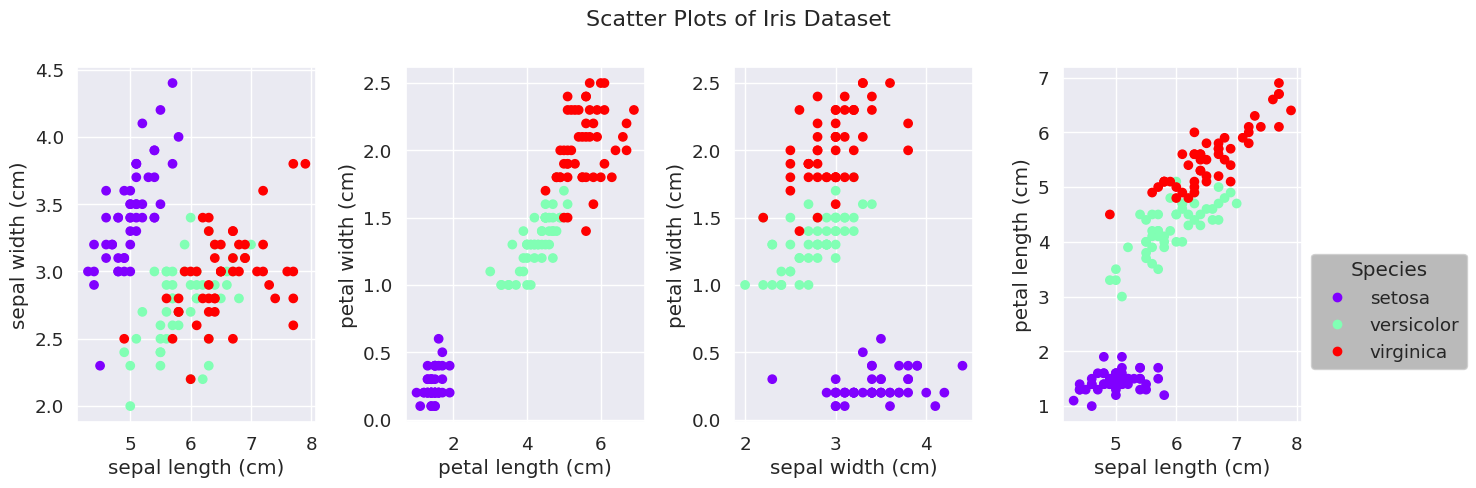

In [36]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

fig.suptitle('Scatter Plots of Iris Dataset', fontsize=16)

# Choose a colormap, for example 'viridis'
colormap = 'rainbow'

# sepal width and sepal length
scatter = axes[0].scatter(iris.data[:, 0], iris.data[:, 1], c=iris.target, cmap=colormap)
axes[0].set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])

# petal width and petal length
scatter = axes[1].scatter(iris.data[:, 2], iris.data[:, 3], c=iris.target, cmap=colormap)
axes[1].set(xlabel=iris.feature_names[2], ylabel=iris.feature_names[3])

# sepal width and petal width
scatter = axes[2].scatter(iris.data[:, 1], iris.data[:, 3], c=iris.target, cmap=colormap)
axes[2].set(xlabel=iris.feature_names[1], ylabel=iris.feature_names[3])

# sepal length and petal length
scatter = axes[3].scatter(iris.data[:, 0], iris.data[:, 2], c=iris.target, cmap=colormap)
axes[3].set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[2])

plt.legend(scatter.legend_elements()[0], iris.target_names, title="Species", bbox_to_anchor=(1,0.5), facecolor='darkgrey')

plt.tight_layout()
plt.show()

**Analysis - Correlation Chart**

From this chart, we can see that the petal length and petal width are the most significant features that determine the flower species.

We can also see, the sepal width is the least important features, similar to what we see in the first heatmap above "Sepal width x Sepal Length".

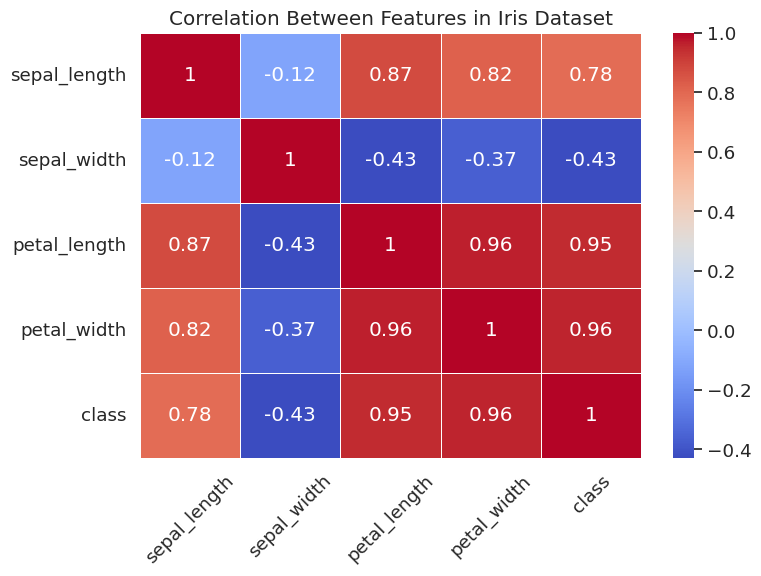

In [37]:
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(dataset.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Between Features in Iris Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Training the model**

Using a support vector machine we create a pipeline for the classifier using different kernels and gamma values.

We are using Standard Scaler as our normalization function; which does zindex normalization, see https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

We split the data using kfold into 5 splits and shuffle the data.

We loop over our data, taking one fold out for testing and then train on the other folds

After fitting the data to the SVM we then evaluate it based on the acccuracy, f1, recall and precision

After each fold calculations are done we then take the average for each metric for comparision

In [38]:
# Define X and Y
X = iris.data  # feature vectors
y = iris.target  # label
# Experiment with different SVM paramaters
# Options documented https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
# 10.1 for gamma is just a random float with no special value
# Based on the docuemntation the degree variable only counts for poly kernels
# When polynomial is selected a degree of 3 is the default
kernelOptions = list(("linear", "poly3", "poly7", "rbf", "sigmoid"))
gammaOptions = list(("scale","auto", 10.1))
results = list()

for gamma in gammaOptions:
    for kernel in kernelOptions:
        if kernel.startswith("poly"):
          degree = int(kernel[-1])
          svm_classifier = make_pipeline(StandardScaler(), SVC(kernel="poly", gamma=gamma,
                                                             degree=degree, random_state=30))
        else:
          svm_classifier = make_pipeline(StandardScaler(), SVC(kernel=kernel, gamma=gamma,
                                                               random_state=30))

        # Implement K-Fold to split the datasets into 5 folds and ensure shuffle is locked
        kf = KFold(n_splits=5, shuffle=True, random_state=40)

        accuracy = list()
        f1_score_result = list()
        recall_score_result = list()
        precision_score_result = list()

        for train_index, test_index in kf.split(X,y):

            # Training and testing data for the fold
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Train
            svm_classifier.fit(X_train, y_train)
            y_pred = svm_classifier.predict(X_test)

            # Evaluation
            accuracy.append(accuracy_score(y_test, y_pred))
            f1_score_result.append(f1_score(y_test, y_pred, average='macro'))
            recall_score_result.append(recall_score(y_test, y_pred, average='macro'))
            precision_score_result.append(precision_score(y_test, y_pred, average='macro'))

        # Store performance of the model
        acc_avg = statistics.mean(accuracy)
        f1_score_avg = statistics.mean(f1_score_result)
        recall_score_avg = statistics.mean(recall_score_result)
        precision_score_avg = statistics.mean(precision_score_result)
        result = [gamma, kernel, acc_avg, f1_score_avg, recall_score_avg, precision_score_avg, acc_avg + f1_score_avg + precision_score_avg + recall_score_avg]

        results.append(result)


**Results**

Our results show that a linear kernel preformed the best regardless of gamma value for all metrics, infact it returned the same results.

However, other kernels such as RBF were sensitive to different gamma values, although only between either scale or auto when compared to the float value of the gamma and scored lower than linear

In [39]:
col_names = ["gamma", "kernel","accuracy","f1_score", "recall", "precision","sum"]

sorted_table = pd.DataFrame(results, columns=col_names).sort_values(by='sum', ascending=False)
sorted_table

,gamma,kernel,accuracy,f1_score,recall,precision,sum
0,scale,linear,0.973333,0.971359,0.972193,0.973575,3.890461
5,auto,linear,0.973333,0.971359,0.972193,0.973575,3.890461
10,10.1,linear,0.973333,0.971359,0.972193,0.973575,3.890461
3,scale,rbf,0.966667,0.965132,0.962670,0.970293,3.864761
8,auto,rbf,0.966667,0.965132,0.962670,0.970293,3.864761
1,scale,poly3,0.933333,0.930886,0.930548,0.946006,3.740774
6,auto,poly3,0.933333,0.930886,0.930548,0.946006,3.740774
11,10.1,poly3,0.933333,0.925123,0.924834,0.938384,3.721674
12,10.1,poly7,0.880000,0.881121,0.889062,0.892095,3.542278
13,10.1,rbf,0.866667,0.869795,0.870570,0.893622,3.500654


**Result Charts**

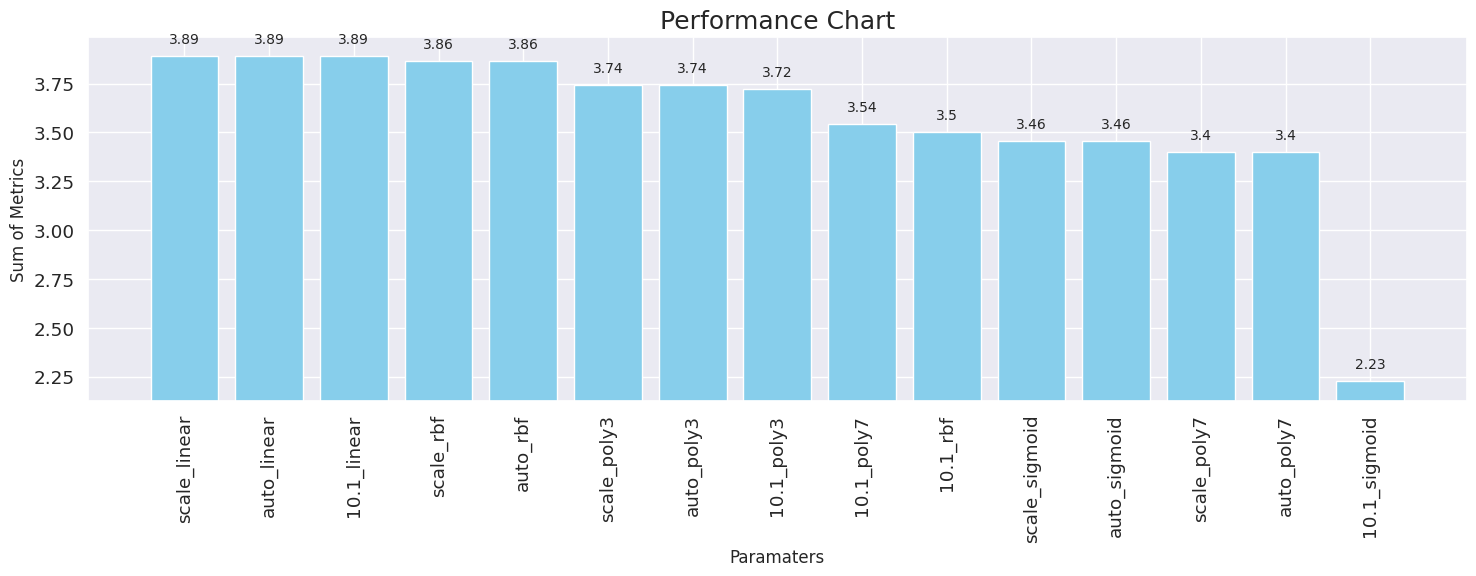

In [40]:
sorted_table['gamma_kernel'] = sorted_table['gamma'].astype(str) + '_' + sorted_table['kernel']

plt.figure(figsize=(15, 6))
plt.bar(range(len(sorted_table)), sorted_table['sum'], color='skyblue')

# Adding labels
plt.xlabel('Paramaters', fontsize=12)
plt.ylabel('Sum of Metrics', fontsize=12)
plt.title('Performance Chart', fontsize=18)
plt.xticks(range(len(sorted_table)), sorted_table['gamma_kernel'] , rotation=90)
plt.ylim(min(sorted_table['sum']) - 0.1, max(sorted_table['sum']) + 0.1)

# Adding values on top of bars
for i, v in enumerate(sorted_table['sum']):
    plt.text(i, v + 0.05, str(round(v, 2)), ha='center', va='bottom', fontsize=10)

# Displaying the plot
plt.tight_layout()
plt.show()